# Broad institute Dataset pre-processing and cleaning 

## Import libraries

In [4]:
import os 
import glob
import pickle
import sys
from collections import defaultdict

import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly_express as px
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.spatial.distance import  squareform
import seaborn as sns
from statsmodels import robust


## Data exploration

### Load data : replicas and  annotations 

- Load annotation data files
- Load replicas present in the All-profiles directory into one data frame 
- Concatenate the data frames into one 

__The dataset__ : 10 080 compounds came from the Molecular Libraries Small Molecule Repository (MLSMR). 2260 were drugs, natural products, and small-molecule probes that are part of the Broad Institute's known bioactive compound collection, 269 were confirmed screening hits from the Molecular Libraries Program (MLP), and 18 051 were novel compounds derived from diversity-oriented synthesis. 

1. Load the chemical annotation file, and check the 2 first line of your annotation file

In [2]:
annotations = pd.read_csv('../Data/chemical_annotations.csv')
annotations.head(2)

,BROAD_ID,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,CPD_SMILES,USERCOMMENT
0,BRD-A56675431-001-04-0,altizide,INN,SA82748,NaN,Prestwick Chemical Inc.,NaN,Prestw-721,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl,NaN
1,BRD-A51829654-001-01-4,"BRL-15,572",common,SA82481,NaN,Biomol International Inc.,NaN,AC-536,OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1,NaN


We are only interested in the first two columns and the 'smiles' column. Therefore, we can drop the others.

In [3]:
desired_col = ["BROAD_ID", "CPD_NAME", "CPD_SMILES"] 
annotations = annotations.loc[:, desired_col]
# one can visualise the data after removing some metadata 
annotations.head(2)

,BROAD_ID,CPD_NAME,CPD_SMILES
0,BRD-A56675431-001-04-0,altizide,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl
1,BRD-A51829654-001-01-4,"BRL-15,572",OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1


2. Load the morphological profile replicas file.
   The profiles are provided in several CSV files. The profiles are split into 63 files to facilitate storage.


In [5]:
path_to_pickle_file = ('../Data')
all_profiles = glob.glob(os.path.join(path_to_pickle_file, "part_*"))

We opem, read and concatenate all the files into one dataframe 

- _NB : The obtain dataframe should have 1800 columns and 153370 lines_ 
    

In [12]:
profiles = pd.concat((pd.read_csv(f) for f in all_profiles), ignore_index=True)
print(f'The dataframe has {profiles.shape[0]} lines and {profiles.shape[1]} columns')
profiles.head(2)

The dataframe has 153370 lines and 1800 columns


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_ASSAY_WELL_ROLE,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,24563,p06,24563,H-CBLB-002-4,p06,treated,BRD-K38538662-001-01-7,5.007141,DMSO,BRD-K38538662,...,2.813017,1.602582,1.522836,1.526843,1.362699,1.421662,1.415197,2.232572,2.223691,2.301858
1,24563,p07,24563,H-CBLB-002-4,p07,treated,BRD-K38571893-001-01-9,4.985294,DMSO,BRD-K38571893,...,2.865297,1.543853,1.543283,1.558455,1.411413,1.520372,1.454489,2.210284,2.243510,2.297205


### Exploration
- Explore the structures and types of the dataframe.
- Harmonise the dataset.
- Merge annotations (name, smiles) with morphological profile.


Once the data is loaded you can explore them using functions like :
-  _.describe()_, which generate descriptive statistics 
-  _.head(n=5)_, which returns the first \( n \) rows. <br>

One can also use attributes like :
- _dtypes_, which return the data type of each column.

In [5]:
pd.DataFrame({'Column': profiles.columns, 'Data_Type': profiles.dtypes})

,Column,Data_Type
Metadata_Plate,Metadata_Plate,int64
Metadata_Well,Metadata_Well,object
Metadata_Assay_Plate_Barcode,Metadata_Assay_Plate_Barcode,int64
Metadata_Plate_Map_Name,Metadata_Plate_Map_Name,object
Metadata_well_position,Metadata_well_position,object
...,...,...
Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_3_0,float64
Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_Mito_5_0,float64
Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_10_0,float64
Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_3_0,float64


1. Removing metadata features <br>
   We noticed that some of the metadata won't be useful, so we drop them.


In [6]:
to_pop = ['Metadata_Well',
          'Metadata_mmoles_per_liter',
          'Metadata_Plate_Map_Name',
          'Metadata_well_position',
          'Metadata_ASSAY_WELL_ROLE',
          'Metadata_solvent',
          'Metadata_pert_id',
          'Metadata_pert_mfc_id',
          'Metadata_pert_well',
          'Metadata_cell_id',
          'Metadata_broad_sample_type',
          'Metadata_pert_vehicle',
          'Metadata_pert_type',
          'Metadata_Assay_Plate_Barcode',
          'Metadata_pert_id_vendor']

# Drop unnecessary columns
profiles.drop(columns=to_pop, inplace=True)

# Move 'Metadata_broad_sample' column upfront
profiles = profiles[['Metadata_broad_sample'] + [col for col in profiles.columns if col != 'Metadata_broad_sample']]


2. Harmonization of the data 

Note that compounds are identified by _Metadata_broad_sample_ in the profile dataframe, but by _BROAD_ID_ in the annotation dataframe.

As we intend to merge these data, we will rename the latter to _Metadata_broad_sample_.

Additionally, we observed that the chemical annotation file does not include a line referring to the mock control DMSO, so we will add it to the annotation file.


In [7]:
annotations = annotations.rename(columns={"BROAD_ID":"Metadata_broad_sample"})
idx = annotations.shape[0]
annotations.loc[idx] = {'Metadata_broad_sample':'DMSO', 'CPD_NAME':'DMSO', 'CPD_SMILES':'CS(=O)C'}

annotations.reset_index(inplace=True)
annotations.drop(columns='index',inplace=True)

print(f'There are {annotations.shape[0]} rows in chemical_annotations.csv files')
print(f'There are {annotations.shape[1]} colunms in chemical_annotation.csv files')
print(f'There are {len(set(profiles.Metadata_broad_sample))} unique Metada molecule id within the Profile dataset')

There are 30617 rows in chemical_annotations.csv files
There are 3 colunms in chemical_annotation.csv files
There are 30617 unique Metada molecule id within the Profile dataset


There are the same number of compounds in both datasets. Now, we can merge them together using '_Metadata_broad_sample_' as the merging feature.


3. Merge the dataframe into one 

In [8]:
profiles = profiles.merge(annotations, how='left', on='Metadata_broad_sample')

# Move 'CPD_NAME' and CPD_SMILES' columns upfront 
cpd = profiles.pop('CPD_NAME')
smile = profiles.pop('CPD_SMILES')

# Concatenate columns
profiles = pd.concat([cpd, smile, profiles], axis=1)

Now our compounds can be identified in 3 ways:

- Metadata_broad_sample: the ID used by the BROAD institute to run the experiment
- CPD_NAME: The molecule compound name as it can be found in public libraries
- CPD_SMILES: The SMILES notation, which will be useful for later work


In [9]:
print(f'There are {len(set(profiles.Metadata_broad_sample))} unique Metada molecule id within this dataset')
print(f'There are {len(set(profiles.CPD_NAME))} unique compound name within this dataset')
print(f'There are {len(set(profiles.CPD_SMILES))} unique compound SMILES within this dataset')

There are 30617 unique Metada molecule id within this dataset
There are 30342 unique compound name within this dataset
There are 30410 unique compound SMILES within this dataset


## Data Inspection: Quality data check

- Removal of noisy features provided by literature.
- Identification of missing values.
- Identification of noisy features.


### Noisy Features

Way and Gregory (2019) identified a list of 55 features for removal.<br>
These features constitute the Blocklist Features - Cell Profiler, available on figshare [https://doi.org/10.6084/m9.figshare.10255811.v3].

1. Load and drop the Blocklist Feature 

In [10]:
blocklist_features = []
path_blocklist_features = ('../data/blocklist_features.txt')
with open(path_blocklist_features, 'r') as file:
    next(file)
    for line in file:
        blocklist_features.append(line.strip())

profiles.drop(blocklist_features, axis=1, inplace=True)

In [11]:
print(f'There are {profiles.shape[0]} replicas for {profiles.shape[1]} features')

There are 153370 replicas for 1732 features


### Remove missing values and constant descriptors


- Check if some columns contain missing values (NaN).
  - Different ways to handle missing values (perform imputation, replace with median value, or drop them) > here, dropped.
- Remove columns with only NA.
  - The column is irrelevant.
- Remove invariant columns, where variance = 0.


1. Missing Value 

In [12]:
columns_with_nan = profiles.columns[profiles.isna().sum() > 0]
print(f'{columns_with_nan.to_list()} contains missing value.')

['CPD_NAME', 'CPD_SMILES'] contains missing value.


The "Name" is not an important feature as it can be replaced by the other identifier. However, the "Smile" identifier is crucial for later analysis.

Once we identify the number of missing treatments or missing smile information, we can either look online and download it or remove it if we consider that we are not losing valuable information.


In [13]:
size = len(set(profiles[profiles['CPD_NAME'].isna()]['Metadata_broad_sample'].to_list()))
print(f'{size} molecules are not provided with smiles, this would mean that at maximum {size*4} profiles are removed from the datase if each of this molecule are performed in quadruplicates')
print(f'There are {profiles.shape[0]} replicas for {profiles.shape[1]} features')

4 molecules are not provided with smiles, this would mean that at maximum 16 profiles are removed from the datase if each of this molecule are performed in quadruplicates
There are 153370 replicas for 1732 features


In [14]:
profiles.dropna(inplace=True)

In [15]:
print(f'There are {profiles.shape[0]} replicas after removing missing values for {profiles.shape[1]} features')
profiles.reset_index(drop=True, inplace=True)

There are 153351 replicas after removing missing values for 1732 features


2. Null or constant variance

In [16]:
constant_features = profiles.columns[np.all(profiles == profiles.iloc[0], axis=0)]
print("Constant features to be removed are:", constant_features.to_list())


Constant features to be removed are: ['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Nuclei_Children_Cells_Count', 'Nuclei_Children_Cytoplasm_Count']


In [17]:
profiles.drop(constant_features.to_list(), axis=1 , inplace=True)
profiles = profiles.reset_index()
profiles.drop(columns='index',inplace=True)

In [18]:
print(f'There are {profiles.shape[0]} replicas after removing null/ constant variance for {profiles.shape[1]} features')

There are 153351 replicas after removing null/ constant variance for 1728 features



### Experimental plates analysis

1. Experimental plates, plates effects


> to do : remove current part and add few line about batch effect analysis 

We look at the features named : Cells_AreaShape_Area

One plate will be removed due to its extremly low values in comparison to the other replicas. This plate has been identified as a bad experiemental plate using the notebook general_outliers_analysis.ipynb

In [19]:
'''plate_25962 = profiles[profiles['Metadata_Plate'] == 25962]
profiles.drop(plate_25962.index,inplace=True)
profiles  = profiles.reset_index()
profiles.drop(['index'],axis=1,inplace = True)
'''

"plate_25962 = profiles[profiles['Metadata_Plate'] == 25962]\nprofiles.drop(plate_25962.index,inplace=True)\nprofiles  = profiles.reset_index()\nprofiles.drop(['index'],axis=1,inplace = True)\n"

### Dead cells 

High-toxicity compounds causing the death of the cells need to be identified and removed from the dataset. The feature *Number_object* or *Count_object* helps to characterize this population. It is considered that values below a certain percentage represent dead cells in comparison to DMSO profiles.

Each plate is inspected, and for every individual within the plate, their Cells_Number_Object_Number value is evaluated to determine if it is less than a certain percentage of the median DMSO value. When this condition is satisfied, the individual's name = molecule name and index are identified and subsequently removed from the dataset.

> The features *_Number_Object_Number* exist for 3 objects, Cells , Nuclei, Cytoplasm. We first check how the 3 correlated as the 3 of them are supposed to relatively identical values

In [20]:

nb_object_df = pd.DataFrame([profiles['Cells_Number_Object_Number'],profiles['Cytoplasm_Number_Object_Number'],profiles['Nuclei_Number_Object_Number' ]]).transpose()
nb_object_df.corr(method='pearson')

,Cells_Number_Object_Number,Cytoplasm_Number_Object_Number,Nuclei_Number_Object_Number
Cells_Number_Object_Number,1.0,1.0,1.0
Cytoplasm_Number_Object_Number,1.0,1.0,1.0
Nuclei_Number_Object_Number,1.0,1.0,1.0


The table shows that the three features are correlated with $( r = 1 $), meaning they provide the same information. Therefore, we choose one feature to continue the analysis.


1. Dead Cells identification

In [21]:
plates_list = list(set(profiles.Metadata_Plate))

In [22]:
len(plates_list)

406

In [23]:

#check if dead cells per plate 

def identify_dead_cells(dataset,plates_num):
    '''
    We check if there are dead cells within each plates  
    Parameters :
        dataset: pandas DataFrame with profiles
        plates_num: list containing unique plate numbers in the dataset
    Return :
         result_index: list of indices in dataset where dead cells were found
         all mols: list of compound names inducing cell death
    '''
    count = 0
    result_index, all_mols = [], []
    for plate in plates_num :

        view_Plate = dataset.loc[dataset['Metadata_Plate']== plate]
        lower_lim = round(view_Plate.loc[view_Plate['Metadata_broad_sample']=='DMSO']['Cells_Number_Object_Number'].median()*0.3)
        mol_name = view_Plate[view_Plate['Cells_Number_Object_Number'] < lower_lim]['Metadata_broad_sample'].to_list()
        
        
        to_drop = view_Plate[view_Plate['Cells_Number_Object_Number'] < lower_lim].index.values.tolist()
        result_index = [*result_index,*to_drop]
        all_mols = [*all_mols,*mol_name]
        count = count + len(to_drop)

    print(f'There are {len(set(all_mols))} unique molecules inducing death for {len(result_index)} profiles to remove' )   

    return result_index, all_mols



In [24]:
idx_dead_cells, mol_name_toxic = identify_dead_cells(profiles,plates_list)

There are 525 unique molecules inducing death for 1822 profiles to remove


2. Dead Cells removal

In [25]:
profiles.drop(labels=idx_dead_cells,inplace=True)

In [26]:
profiles.reset_index(inplace=True)
profiles.drop(columns='index',inplace=True)

In [27]:
print(f'Now, we obtain {profiles.shape[0]} profiles') 

Now, we obtain 151529 profiles



### Investigation of DMSO replicas

* Here we remove DMSO outliers by looking into DMSO's distribution of distance
* Additionally we remove DMSOs by keeping the same ratio of DMSO per plate


In [28]:
replica_control = profiles.loc[profiles['Metadata_broad_sample'] == 'DMSO']
print(f'Dimension of control dataframe is {replica_control.shape}')
replica_control.iloc[:,3:].head(2)

Dimension of control dataframe is (26560, 1728)


,Metadata_Plate,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,25692,4128.0,346.0,253.5,1.258979,0.817046,0.568889,0.348658,99.105440,107.258866,...,3.757766,1.423576,1.476285,1.445165,1.642289,1.875568,1.760791,2.450487,2.348636,2.416143
1,25692,3680.0,375.0,270.0,1.285019,0.821609,0.541943,0.336312,95.870835,101.843016,...,3.032794,1.374216,1.390197,1.393801,1.552905,1.686087,1.609445,2.246500,2.262934,2.316178




The next lines consist in :

* Creating a data frame with the plate identifier and theire number of DMSO per plate
* Getting the plate identifier where DMSO ratio > 17
* Keeping a ratio of 16 % Dmso per plate
* Getting the index of random DMSO profiles that needs to be removed
* Merging the Dmso to keep with the initial data frame



In [29]:
def get_ratios(data):
    '''
    get the ratio of DMSO per plate 
    number control/plate (16 % of the plates is DMSO ) ; ((384-294)*64) / 384
    '''
    ratios = {}
    list_plates = list(set(data['Metadata_Plate']))
    
    for plate in list_plates :
        if plate not in ratios : 
            ratios[plate] = round((data[ (data['Metadata_Plate'] == plate ) & (data['Metadata_broad_sample'] == 'DMSO') ].shape[0]) / (data[data['Metadata_Plate'] == plate].shape[0]),3)
    
    df_ratios = pd.DataFrame.from_dict(ratios,orient='index',columns=['Ratio_DMSO'])
    df_ratios['Ratio_DMSO'] = df_ratios['Ratio_DMSO'] * 100
    df_ratios['Metadata_Plate'] = list_plates
    return df_ratios

In [30]:
df_ratios = get_ratios(profiles)

In [31]:
df = pd.DataFrame(data={'plates': list(replica_control['Metadata_Plate'].value_counts().index), 'nb':list(replica_control['Metadata_Plate'].value_counts())})
plate_id_to_check= df_ratios[ (df_ratios['Ratio_DMSO'] > 17 )]['Metadata_Plate'].to_list()

In [32]:
df_ratios_check = get_ratios(profiles)
plates_num_to_study = df_ratios_check[ (df_ratios['Ratio_DMSO'] > 17 )]['Metadata_Plate'].to_list()

In [33]:
def to_keep(plates_num,all_data,control_dataset):
    '''
    Lower the ratios of DMSO per plate to 16%
    Resampling the control per plate to the same ratio (16%), for plate having more than 64 control
    as the averae number of DMSO per plate is 64 and that one plate contains 384 replicas  
        Parameters : 
            plates_num (list): identifier of plates with a high number of DMSO
            all_data (data frame): all profiles 
            control_dataset (data frame): DMSO only profiles
        Returns : 
            appended_data (list) : DMSO profiles to keep 
    '''
    appended_data = []
    for nb in plates_num: 
        nb_profiles = all_data[all_data['Metadata_Plate'] == nb].shape[0]
        nb_control = all_data[(all_data['Metadata_Plate'] == nb ) & (all_data['Metadata_broad_sample'] == 'DMSO') ].shape[0]
        a = round(0.166 * (nb_profiles - nb_control))
        keep = control_dataset.loc[control_dataset['Metadata_Plate'] == nb].sample(n=a,random_state=101) #check different seedm7 bad
        appended_data.append(keep)
    return appended_data

appended_data = to_keep(plates_num_to_study,profiles,replica_control)  
control_to_keep = pd.concat(appended_data) 

> to do conclusion of the above step 

In [34]:
replicas = profiles.copy(deep=True)

for plate in plate_id_to_check:
    replicas.drop(replicas[ (replicas['Metadata_Plate'] == plate ) & (replicas['Metadata_broad_sample'] == 'DMSO') ].index,inplace=True)

replicas_t = pd.concat([replicas,control_to_keep])
replicas_t.shape 

ratios_replicas = get_ratios(replicas_t) 
ratios_replicas.sort_values(axis=0,by='Ratio_DMSO',ascending=False)

# remove the plate that has 99 % of dmso and one replicas 
empty_plate = ratios_replicas[ (ratios_replicas['Ratio_DMSO'] == 0 ) ]['Metadata_Plate'].to_list()

replicas_t = replicas_t[~replicas_t['Metadata_Plate'].isin(empty_plate)]

replicas_t.reset_index(inplace=True)
replicas_t.drop(columns='index',inplace=True)

profiles = replicas_t.copy(deep=True)

> TO DO: Conclusion after dropping DMSO plate


## Feature normalization


### Modified Z-Score

The modified Z-score is a variation of the traditional Z-score that is more robust to outliers. While the classic Z-score is calculated using the mean and standard deviation of a dataset, the modified Z-score uses the median and median absolute deviation (MAD) instead. Modified Z-score is a robust measure of how many standard deviations a data point is from the median of the DMSO, providing a more stable measure of deviation from the central tendency in the presence of outliers.

The formula for the modified Z-score is:

$$
\text{Modified Z-score} = \frac{{(X - \text{Median})}}{{\text{MAD}}}
$$

where \( X \) is the value of the data point, Median is the median of the DMSO, and MAD is the median absolute deviation.


In [36]:
def progress_bar(index, total, label):
    n_bar = 50  
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

def fragment_data(dataset,num):
    '''
    Fragment the initial data frame into plate batches 
        
        Parameters : 
            dataset(data frame): Profiles 
            num(list): Plate identifer 
        
        Returns    :
            list_df(list): Plates (profiles) contained within a list 
    '''
    list_df = [dataset.loc[dataset['Metadata_Plate']== int(nb)].copy(deep = True) for nb in num ]
    return list_df 

def center_plate(dataset,num):
    '''
    Scaling data with a z-score scaler
        
        Parameters : 
            dataset(data frame): Profiles 
            num(list): Plate identifer 
        
        Returns    :
            l_df   : Updated plates (profiles) contain within a list 
    '''
    
    l_df = fragment_data(dataset,num)
    
    tot=len(num)
    
    for n in range(0,tot):
        progress_bar(n+1,tot,"of z-score scaling")
        non_numerical_columns = ['CPD_NAME', 'Metadata_Plate', 'Metadata_broad_sample', 'CPD_SMILES']
        dmso_samples = l_df[n]['CPD_NAME']== 'DMSO'
        z_score_scaler = lambda df: df.apply(lambda x:(x - np.median(x[dmso_samples]))/(robust.mad(x[dmso_samples])*1.4826), axis = 0)
        l_df[n].update(z_score_scaler(l_df[n].loc[:,np.isin(l_df[n].columns, non_numerical_columns, invert=True)].copy(deep=True))) 
    return l_df

In [37]:
l_scaled_data = center_plate(profiles,plates_list)
z_score_normalized_profiles = pd.concat(l_scaled_data, ignore_index=True)

[==================================================] 100%  of z-score scaling

In [38]:
# Check for infinite values
if np.isinf(z_score_normalized_profiles.iloc[0:,4:]).any().any():
    print("DataFrame contains infinite values.")
else:
    print("DataFrame does not contain infinite values.")

DataFrame contains infinite values.


In [39]:
to_drop = []
for column in z_score_normalized_profiles.columns:
    if not column in ['CPD_NAME', 'Metadata_Plate', 'Metadata_broad_sample', 'CPD_SMILES']:
        if not np.isinf(z_score_normalized_profiles[column]).values.sum() == 0:
            to_drop.append(column)
print(f'There are {len(to_drop)} features with infinite values, which we are going to drop.')

There are 243 features with infinite values, which we are going to drop.


In [40]:
z_score_normalized_profiles.drop(to_drop, axis='columns', inplace=True)
print(f'Scaled data dimension : {z_score_normalized_profiles.shape }')

Scaled data dimension : (149081, 1485)


##  Aggregation 


After scaling the data, we collapse all replicas from one compound into one unique median morphological profile.

In [41]:
print(f'There are {len(set(z_score_normalized_profiles.Metadata_broad_sample))} unique Metada molecule id within this dataset')
print(f'There are {len(set(z_score_normalized_profiles.CPD_NAME))} unique compound name within this dataset')
print(f'There are {len(set(z_score_normalized_profiles.CPD_SMILES))} unique compound SMILES within this dataset')

There are 30377 unique Metada molecule id within this dataset
There are 30112 unique compound name within this dataset
There are 30177 unique compound SMILES within this dataset


We are using Metadata molecule id to merge the replicas into treatment profiles because 

In [42]:
z_score_agreg = z_score_normalized_profiles.groupby(['Metadata_broad_sample'],sort=False,dropna=True).median(numeric_only=True).reset_index()
#["CPD_NAME", "CPD_SMILES"]
z_score_agreg.drop(labels='Metadata_Plate',axis=1,inplace=True)
z_score_agreg = z_score_agreg.dropna(axis = "columns", how = 'any')

We need to keep the CPD_NAMES and CPD_SMILES for the next part.

In [43]:
z_score_agreg = annotations.merge(z_score_agreg, how='right', on='Metadata_broad_sample')
z_score_agreg

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.071990,2.241229,0.995284,2.384573,1.070973,-2.233921,-0.757944,...,2.187914,1.170176,0.861472,0.880412,-0.774194,-1.601103,-1.264738,-1.615324,-0.768571,-1.572966
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.670867,1.411121,0.147575,1.100819,0.762929,-1.362762,-1.413523,...,2.231732,0.272964,0.830997,0.883476,-1.796194,-2.168508,-2.010265,-2.594994,-2.322683,-2.768578
2,BRD-K41006887-001-01-9,BRD-K41006887,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.085378,1.556283,1.259968,1.498730,1.114962,-1.464056,0.707534,...,2.203882,-0.014940,-0.216334,-0.166405,-1.007664,-1.614786,-1.337034,-0.919517,-0.925715,-0.913952
3,BRD-K06226868-001-01-9,BRD-K06226868,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1NC...,-0.711054,-0.623213,0.859805,-0.276229,-0.079732,-0.740941,0.099216,...,1.587450,0.054517,-0.035844,0.217959,-2.186638,-2.224412,-2.201833,0.906520,0.358574,0.713604
4,BRD-K80296876-001-01-1,BRD-K80296876,OC[C@@H]1O[C@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.950244,-0.461241,0.947382,-0.579862,-0.258797,0.412306,-0.254541,...,1.884930,-0.033023,0.043971,0.069601,0.572740,0.374491,0.406468,1.282397,1.883234,1.527618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30372,BRD-K39052671-001-01-7,BRD-K39052671,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)c2cccc...,2.516120,1.078452,-0.312006,4.486700,3.383996,-1.764702,-0.468625,...,0.517221,-0.400231,-0.512823,-0.474644,-2.461012,-2.150594,-2.100665,-0.171993,-0.241309,-0.000684
30373,BRD-K39090122-001-01-2,BRD-K39090122,C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)CCCN(C)C...,2.655779,1.160822,0.765046,3.267407,2.156068,-1.537529,0.025517,...,0.362311,-0.157143,-0.120285,-0.315003,-1.312273,-1.388629,-1.538623,0.102142,-0.056891,0.087763
30374,BRD-K39107553-001-01-2,BRD-K39107553,C[C@H](CO)N1C[C@H](C)[C@H](CN(C)Cc2ccncc2)OCCC...,3.077586,0.433757,-0.695039,3.040360,2.694176,-2.202421,-1.090799,...,1.002740,0.235786,-0.087614,-0.006685,-1.034057,-0.963250,-1.128451,0.323291,0.027148,0.054536
30375,BRD-K39179354-001-01-2,BRD-K39179354,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc3O...,2.507624,1.903560,0.267620,5.384234,3.427121,-2.059246,-0.574591,...,0.708084,0.601872,1.162783,1.241112,-2.317733,-2.796682,-2.640121,-1.101079,-1.448399,-0.940164


### Features reduction 

This part consists of reducing the collinearity between features using Pearson correlation and a minimal redundancy and maximal relevance algorithm.

1. Reduce colinearity 

In [45]:
#profiles = pd.read_pickle('../data/z_score_agreg.pkl')
profiles = z_score_agreg
data = profiles.iloc[:,3:]

In [46]:
profiles.iloc[:,2:]

,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.071990,2.241229,0.995284,2.384573,1.070973,-2.233921,-0.757944,0.425989,0.361661,...,2.187914,1.170176,0.861472,0.880412,-0.774194,-1.601103,-1.264738,-1.615324,-0.768571,-1.572966
1,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.670867,1.411121,0.147575,1.100819,0.762929,-1.362762,-1.413523,-0.322607,-0.270388,...,2.231732,0.272964,0.830997,0.883476,-1.796194,-2.168508,-2.010265,-2.594994,-2.322683,-2.768578
2,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.085378,1.556283,1.259968,1.498730,1.114962,-1.464056,0.707534,0.418125,0.291458,...,2.203882,-0.014940,-0.216334,-0.166405,-1.007664,-1.614786,-1.337034,-0.919517,-0.925715,-0.913952
3,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1NC...,-0.711054,-0.623213,0.859805,-0.276229,-0.079732,-0.740941,0.099216,-0.606435,-0.695482,...,1.587450,0.054517,-0.035844,0.217959,-2.186638,-2.224412,-2.201833,0.906520,0.358574,0.713604
4,OC[C@@H]1O[C@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.950244,-0.461241,0.947382,-0.579862,-0.258797,0.412306,-0.254541,-1.082099,-1.184737,...,1.884930,-0.033023,0.043971,0.069601,0.572740,0.374491,0.406468,1.282397,1.883234,1.527618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30372,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)c2cccc...,2.516120,1.078452,-0.312006,4.486700,3.383996,-1.764702,-0.468625,2.656603,2.410376,...,0.517221,-0.400231,-0.512823,-0.474644,-2.461012,-2.150594,-2.100665,-0.171993,-0.241309,-0.000684
30373,C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)CCCN(C)C...,2.655779,1.160822,0.765046,3.267407,2.156068,-1.537529,0.025517,2.552476,2.682044,...,0.362311,-0.157143,-0.120285,-0.315003,-1.312273,-1.388629,-1.538623,0.102142,-0.056891,0.087763
30374,C[C@H](CO)N1C[C@H](C)[C@H](CN(C)Cc2ccncc2)OCCC...,3.077586,0.433757,-0.695039,3.040360,2.694176,-2.202421,-1.090799,3.325555,3.324161,...,1.002740,0.235786,-0.087614,-0.006685,-1.034057,-0.963250,-1.128451,0.323291,0.027148,0.054536
30375,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc3O...,2.507624,1.903560,0.267620,5.384234,3.427121,-2.059246,-0.574591,2.531225,2.453060,...,0.708084,0.601872,1.162783,1.241112,-2.317733,-2.796682,-2.640121,-1.101079,-1.448399,-0.940164


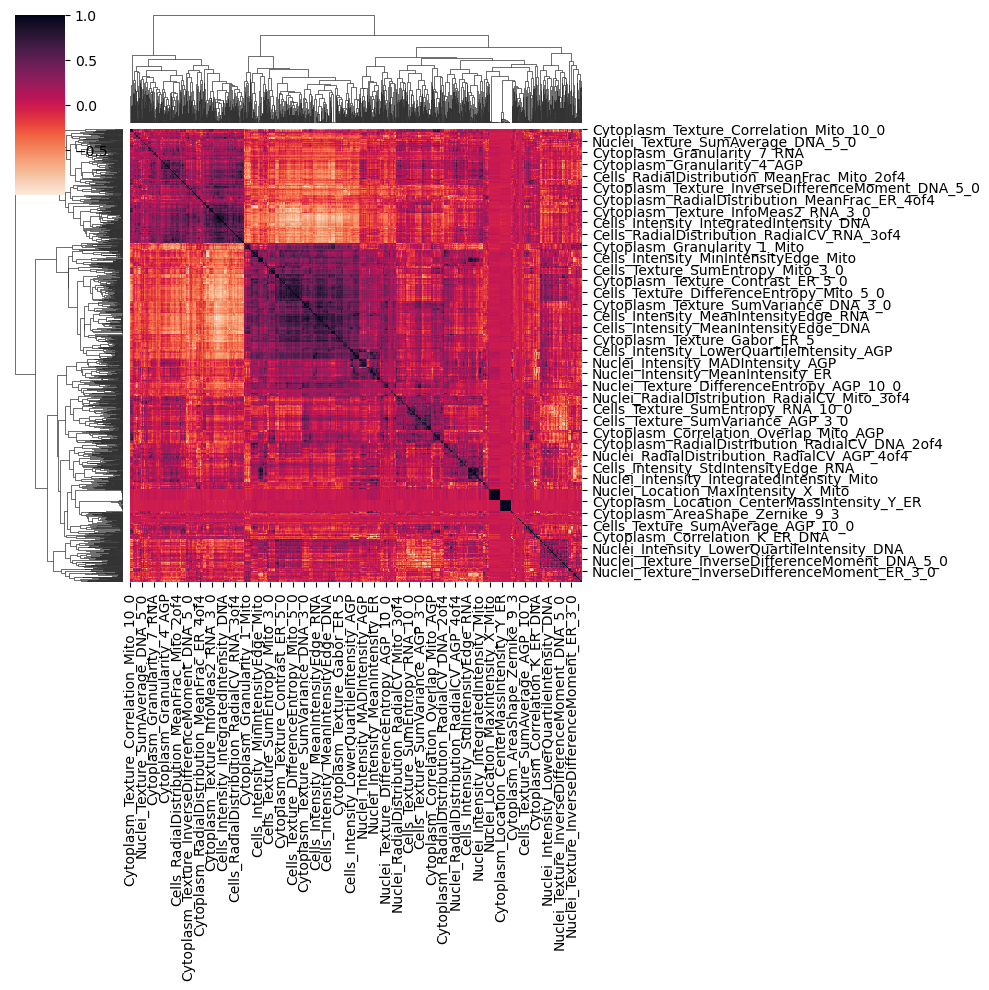

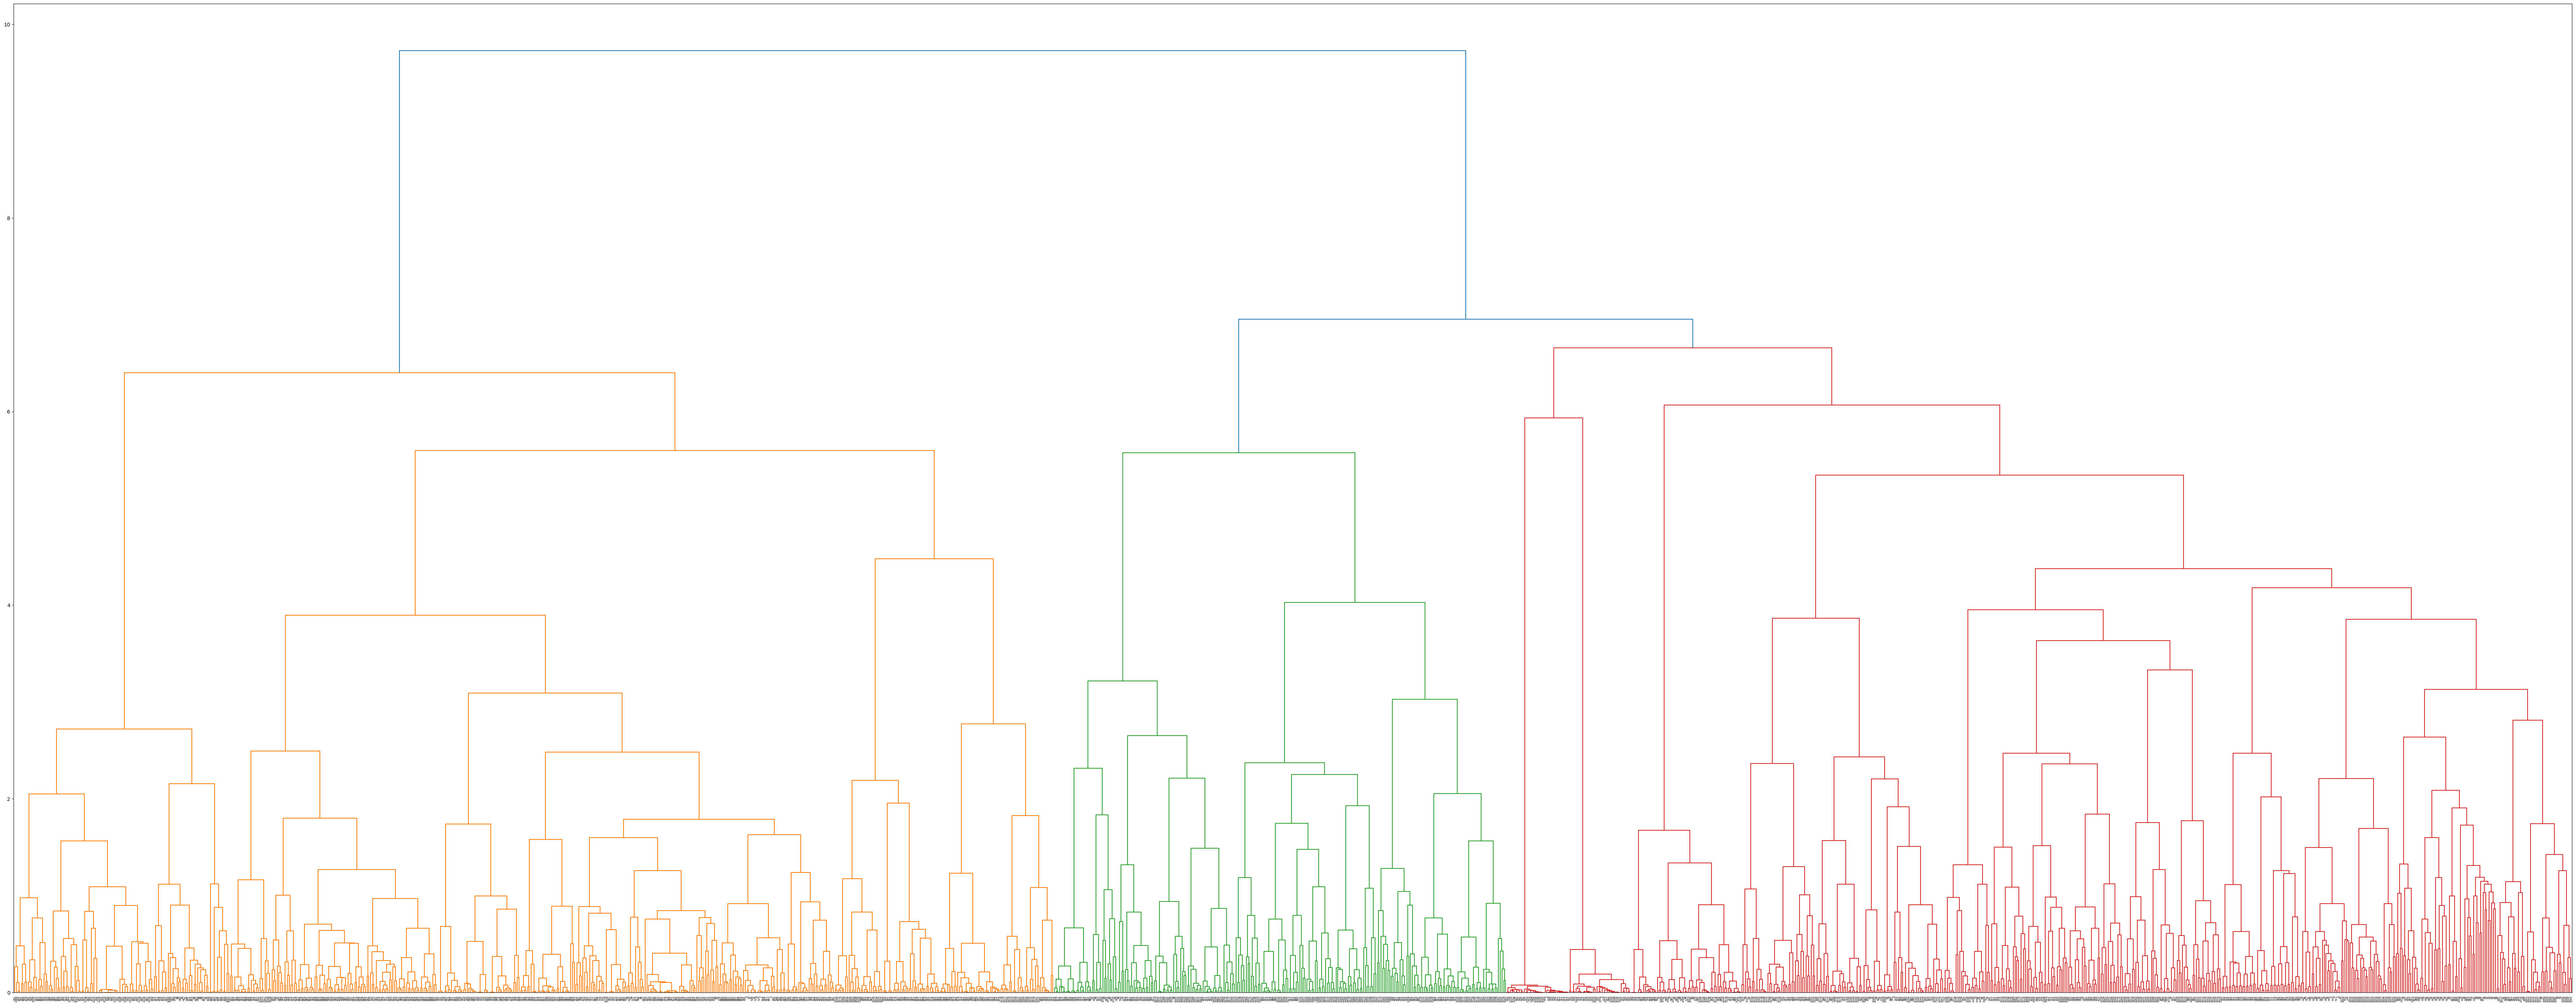

In [47]:
corr = data.corr(numeric_only=True)
sns_plot = sns.clustermap(data.corr(numeric_only=True), cmap="rocket_r")

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = scipy.cluster.hierarchy.ward(squareform(distance_matrix))

fig = plt.figure(figsize=(90, 35))
dn = dendrogram(dist_linkage)
plt.show()


In [53]:

cluster_ids = scipy.cluster.hierarchy.fcluster(dist_linkage, 0.2, criterion="distance") # check distance cutoff because the higher we cut less group we obtain and less features are selected (1 for each group)
cluster_id_to_feature_ids = defaultdict(list)

#create a dict for each cluster and add features indx as value  
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [54]:
selected_features_names = data.columns[selected_features]
print(f'{len(selected_features_names)} features are kept')

579 features are kept


In [55]:
profiles.iloc[:,:3]

,Metadata_broad_sample,CPD_NAME,CPD_SMILES
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...
2,BRD-K41006887-001-01-9,BRD-K41006887,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...
3,BRD-K06226868-001-01-9,BRD-K06226868,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1NC...
4,BRD-K80296876-001-01-1,BRD-K80296876,OC[C@@H]1O[C@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...
...,...,...,...
30372,BRD-K39052671-001-01-7,BRD-K39052671,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)c2cccc...
30373,BRD-K39090122-001-01-2,BRD-K39090122,C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)CCCN(C)C...
30374,BRD-K39107553-001-01-2,BRD-K39107553,C[C@H](CO)N1C[C@H](C)[C@H](CN(C)Cc2ccncc2)OCCC...
30375,BRD-K39179354-001-01-2,BRD-K39179354,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc3O...


In [56]:

aggregated_profiles = pd.concat([profiles.iloc[:,:3],profiles[selected_features_names]],axis=1)

> to do : choose an optimal treshold 
 Calculate  within-cluster var for diff distance -> np.arrange(0.1, 2, 0.5)

 Plot  graph of within-cluster variance

 Find the optimal cutoff distance using the elbow method

  use the optimal cutoff distance to cluster your data

 create a dict for each cluster and add feature index as value
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

## Pickle final Data 

In [57]:
aggregated_profiles.to_pickle("../data/z_score_agreg.pkl")

## Conclusion

In [58]:
print(f'After different steps of pre-processing, we obtained a treatment level profiles for {z_score_agreg.shape[0]} molecules')

After different steps of pre-processing, we obtained a treatment level profiles for 30377 molecules
